# Real-Time Emotion Based Music Player

## Imports and Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
from collections import Counter
import numpy as np
import random
from tqdm.notebook import tqdm
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import webbrowser
import cv2
from collections import deque
import torch.nn.functional as F

# Set device to CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# Ensure CUDA is available
if not torch.cuda.is_available():
    raise RuntimeError('CUDA not available. Please use a GPU for training from scratch.')

Device: cuda


## Data Cleaning

In [2]:
data_root = r"M:/xzc/DATA/DATASET"
train_dir = os.path.join(data_root, 'train')
test_dir = os.path.join(data_root, 'test')

# Function to clean and get class distribution
def clean_and_count(root_dir, split_name):
    valid_images = []
    class_counts = {}
    
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(root, file)
                try:
                    img = Image.open(img_path)
                    img.verify()
                    img.close()
                    valid_images.append(img_path)
                    
                    # Get class from folder
                    class_name = os.path.basename(root)
                    class_counts[class_name] = class_counts.get(class_name, 0) + 1
                
                except Exception as e:
                    print(f'Corrupt image: {img_path} - {e}')
                    # os.remove(img_path)  # Uncomment to delete
    
    print(f'{split_name} split: {len(valid_images)} valid images')
    print(f'{split_name} class distribution: {class_counts}')
    
    return valid_images, class_counts

train_valid, train_counts = clean_and_count(train_dir, 'Train')
test_valid, test_counts = clean_and_count(test_dir, 'Test')

Train split: 12271 valid images
Train class distribution: {'1': 1290, '2': 281, '3': 717, '4': 4772, '5': 1982, '6': 705, '7': 2524}
Test split: 3068 valid images
Test class distribution: {'1': 329, '2': 74, '3': 160, '4': 1185, '5': 478, '6': 162, '7': 680}


## SOTA Preprocessing (Transforms and Data Loaders)

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.3, 3.3))
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets (ImageFolder will handle valid images due to cleaning)
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
test_dataset = ImageFolder(root=test_dir, transform=test_transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Check classes
print(f'Classes: {train_dataset.classes}')
print(f'Num classes: {len(train_dataset.classes)}')

Classes: ['1', '2', '3', '4', '5', '6', '7']
Num classes: 7


## Visualization

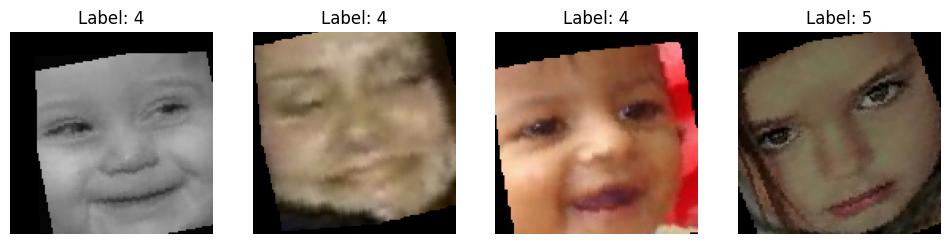

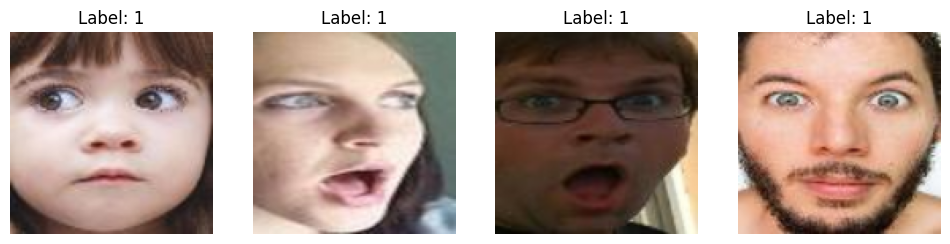

In [4]:
def show_batch(dataloader, class_names, num_images=4):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    
    # Denormalize
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    images = images * std + mean
    
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
    for i in range(num_images):
        npimg = images[i].numpy().transpose(1, 2, 0)
        npimg = np.clip(npimg, 0, 1)
        axes[i].imshow(npimg)
        axes[i].set_title(f'Label: {class_names[labels[i]]}')
        axes[i].axis('off')
    plt.show()

# Show train batch
show_batch(train_loader, train_dataset.classes)

# Show test batch
show_batch(test_loader, test_dataset.classes)

## Model Architecture

In [5]:
# Design explanation: This is a VGG-style deep CNN with 5 convolutional blocks, increasing channels progressively for feature extraction.
# Each block consists of two conv layers with batch norm and ReLU, followed by max pool. This allows capturing hierarchical features.
# Global Average Pooling reduces parameters and provides better regularization compared to flatten.
# Dropout prevents overfitting in the classifier.

class CustomDeepEmotionNet(nn.Module):
    def __init__(self, num_classes=7):
        super(CustomDeepEmotionNet, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # Block 1: 32 channels
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 2: 64 channels
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 3: 128 channels
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 4: 256 channels
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 5: 512 channels
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate model
model = CustomDeepEmotionNet(num_classes=len(train_dataset.classes))
model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(model)

Total parameters: 4,719,783
Trainable parameters: 4,719,783
CustomDeepEmotionNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, str

## Training Configuration

In [6]:
# Label Smoothing Cross Entropy
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        confidence = 1. - self.smoothing
        log_probs = nn.functional.log_softmax(pred, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

# Loss, Optimizer, Scheduler
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Accuracy function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

C:\Users\moazh\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training Loop

In [ ]:
num_epochs = 45
best_val_acc = 0.0
best_model_path = r"M:\xzc\custom_emotion_model.pth"

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    
    train_pbar = tqdm(train_loader, desc=f'Train Epoch {epoch+1}/{num_epochs}')
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += accuracy(outputs, labels)
        
        train_pbar.set_postfix(loss=f'{train_loss/len(train_loader):.4f}', acc=f'{train_acc/len(train_loader):.4f}')
    
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    
    val_pbar = tqdm(test_loader, desc=f'Val Epoch {epoch+1}/{num_epochs}')
    with torch.no_grad():
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            val_acc += accuracy(outputs, labels)
            
            val_pbar.set_postfix(loss=f'{val_loss/len(test_loader):.4f}', acc=f'{val_acc/len(test_loader):.4f}')
    
    val_loss /= len(test_loader)
    val_acc /= len(test_loader)
    
    # Step scheduler (based on val_loss)
    scheduler.step(val_loss)
    
    # Print metrics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Save model only if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f'Saved best model with val acc: {best_val_acc:.4f}')

print('Training complete.')
print(f'Best Val Accuracy: {best_val_acc:.4f}')

## Model Testing

C:\Users\moazh\AppData\Local\Temp\ipykernel_16792\3447521355.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_locati

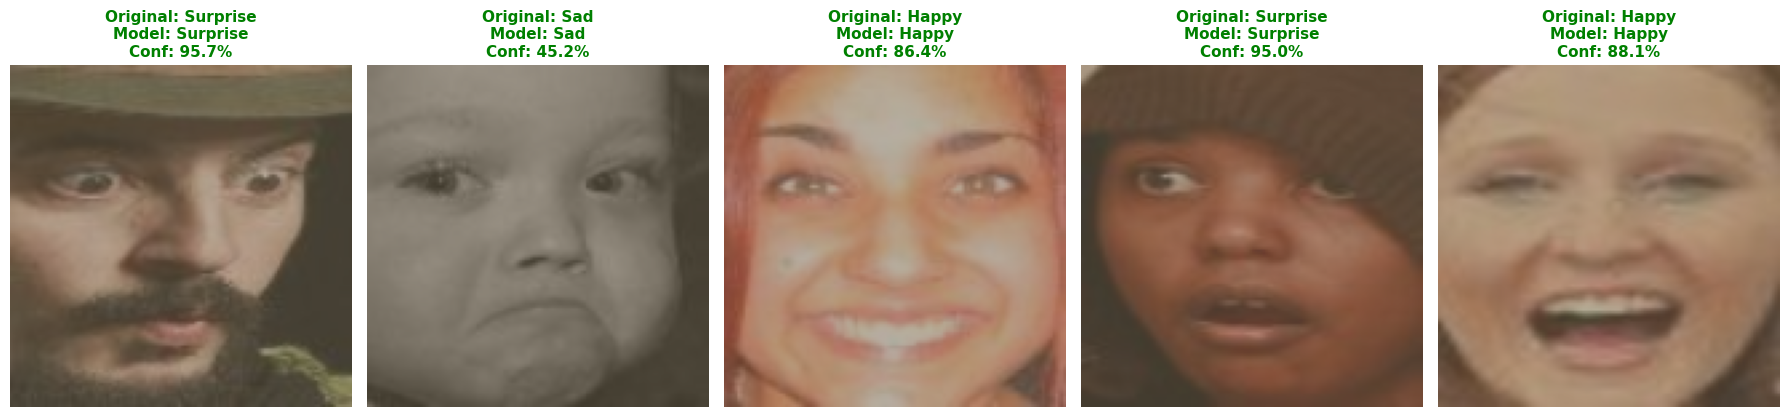

Inference complete. Shown: Original Label vs Model Prediction.


In [7]:
import random

class_names = ['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Angry', 'Neutral']
best_model_path = 'custom_emotion_model.pth'

model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

num_samples = 5
indices = random.sample(range(len(test_dataset)), num_samples)

fig, axes = plt.subplots(1, num_samples, figsize=(18, 5))
softmax = nn.Softmax(dim=1)

for i, idx in enumerate(indices):
    img, label = test_dataset[idx]
    
    img_input = img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_input)
        probs = softmax(output).squeeze()
        pred_idx = torch.argmax(probs).item()
        confidence = probs[pred_idx].item() * 100
    
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    img_display = img.clone().cpu()
    img_display = img_display * std + mean
    img_display = torch.clamp(img_display, 0, 1)
    
    npimg = img_display.numpy().transpose(1, 2, 0)
    axes[i].imshow(npimg)
    
    true_name = class_names[label]
    pred_name = class_names[pred_idx]
    
    color = 'green' if label == pred_idx else 'red'
    
    title_text = f"Original: {true_name}\nModel: {pred_name}\nConf: {confidence:.1f}%"
    
    axes[i].set_title(title_text, color=color, fontsize=11, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print('Inference complete. Shown: Original Label vs Model Prediction.')

## Spotify Integration

In [ ]:
class SpotifyPlaylistMaker:
    def __init__(self, client_id, client_secret):
        scope = "playlist-modify-public user-library-read"
        self.sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
            client_id=client_id,
            client_secret=client_secret,
            redirect_uri="http://127.0.0.1:8888/callback",
            scope=scope
        ))
        
        try:
            self.user_id = self.sp.current_user()['id']
            print(f"Connected to Spotify as: {self.user_id}")
        except Exception as e:
            print("Connection Failed.")
            print(e)
        
        self.mood_queries = {
            'Happy': ['Happy Pop Hits', 'Feel Good Songs', 'Summer Hits'],
            'Sad': ['Sad Piano', 'Heartbreak Songs', 'Acoustic Ballads'],
            'Angry': ['Heavy Metal Essentials', 'Hard Rock Workout', 'Rage Beats'],
            'Neutral': ['Lo-Fi Beats', 'Chill Vibes', 'Study Music'],
            'Surprise': ['Party Anthems', 'Electronic Dance', 'Viral Hits'],
            'Fear': ['Dark Classical', 'Horror Soundtracks', 'Suspense Music'],
            'Disgust': ['Grunge Essentials', 'Alternative Rock', 'Punk Rock']
        }

    def create_mood_playlist(self, mood):
        if mood not in self.mood_queries:
            return None

        query = random.choice(self.mood_queries[mood])
        print(f"Mood: {mood} | Searching for: '{query}'...")
        
        try:
            playlist_name = f"My {mood} Mood Mix "
            playlist = self.sp.user_playlist_create(
                user=self.user_id, name=playlist_name, public=True,
                description=f"Auto-generated by AI Mood DJ using search query: {query}"
            )
            playlist_id = playlist['id']
            playlist_url = playlist['external_urls']['spotify']

            results = self.sp.search(q=query, limit=20, type='track')
            
            track_uris = []
            for track in results['tracks']['items']:
                track_uris.append(track['uri'])

            if track_uris:
                random.shuffle(track_uris)
                self.sp.playlist_add_items(playlist_id, track_uris)
                print(f"Success! Added {len(track_uris)} tracks from search.")
                return playlist_url
            else:
                print("Playlist created but search returned no results.")
                return playlist_url

        except Exception as e:
            print(f"Error: {e}")
            return None
            


Search-Mode Setup Complete! Now Run the App Cell.


## Main Application

In [ ]:
# --- CONFIGURATION ---
# 1. Spotify Credentials
CLIENT_ID = '87121f01737f4da1824c7df1cd09f594'
CLIENT_SECRET = '5a62a634dfa440e885a5989bd6c16ad3'

# 2. Load Resources
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_names = ['Surprise', 'Disgust', 'Angry', 'Happy', 'fear', 'Sad', 'Neutral']

# Load Model
model = CustomDeepEmotionNet(num_classes=len(class_names)).to(device)
try:
    model.load_state_dict(torch.load('custom_emotion_model.pth', map_location=device))
    print("Model loaded successfully.")
except:
    print("Model file not found! Make sure to run Training cells first.")

model.eval()

# Initialize Spotify DJ
print("⏳ Connecting to Spotify...")
dj_maker = SpotifyPlaylistMaker(CLIENT_ID, CLIENT_SECRET)

# Transforms
inference_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Setup Camera
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
probs_deque = deque(maxlen=10) 

feedback_msg = ""
feedback_timer = 0

print("\nWebcam started!")
print("IMPORTANT: Click on the Video Window first!")
print("Controls: [P] -> Create Playlist | [Q] -> Quit")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break
    
    frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    current_label = None 

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        try:
            roi = frame[y:y+h, x:x+w]
            if roi.size == 0: continue
            
            roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(roi_rgb)
            
            tensor = inference_transform(pil_img).unsqueeze(0).to(device)
            
            with torch.no_grad():
                out = model(tensor)
                probs = F.softmax(out, dim=1).cpu().numpy().squeeze()
            
            probs_deque.append(probs)
            avg_probs = np.mean(probs_deque, axis=0)
            idx = np.argmax(avg_probs)
            confidence = avg_probs[idx] * 100
            current_label = class_names[idx]
            
            color = (0, 255, 0) if confidence > 60 else (0, 255, 255)
            text = f"{current_label} ({confidence:.1f}%)"
            cv2.putText(frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
            
        except Exception as e:
            pass

    # --- UI & Controls ---
    cv2.putText(frame, "Click Window -> Press 'P' for Playlist | 'Q' to Quit", (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

    key = cv2.waitKey(10) & 0xFF
    
    if key != 255: 
        print(f"Key Pressed: {chr(key)} (Code: {key})")

    
    if key == ord('q') or key == ord('Q'):
        print("Quitting...")
        break
        
    
    elif key == ord('p') or key == ord('P'):
        print(f"Button 'P' detected! Current Mood: {current_label}")
        if current_label:
            cv2.putText(frame, "Creating Playlist...", (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            cv2.imshow('AI Mood DJ', frame)
            cv2.waitKey(1) 
            
            url = dj_maker.create_mood_playlist(current_label)
            if url:
                webbrowser.open(url)
                feedback_msg = f"Playlist Ready: {current_label}"
                feedback_timer = 50
        else:
            feedback_msg = "No face detected!"
            feedback_timer = 20

    if feedback_timer > 0:
        cv2.putText(frame, feedback_msg, (50, 250), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        feedback_timer -= 1

    cv2.imshow('AI Mood DJ', frame)

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

C:\Users\moazh\AppData\Local\Temp\ipykernel_16792\3047867597.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('custom_emotion_model.pth'

Model loaded successfully.
⏳ Connecting to Spotify...
Connected to Spotify as: 31vik7zrudgynvi323hql5uflhbq

Webcam started!
IMPORTANT: Click on the Video Window first!
Controls: [P] -> Create Playlist | [Q] -> Quit
Key Pressed: p (Code: 112)
Button 'P' detected! Current Mood: Angry
Mood: Angry | Searching for: 'Heavy Metal Essentials'...
Success! Added 20 tracks from search.
Key Pressed: q (Code: 113)
Quitting...


-1